# Image classification: dogs & cats

In [2]:
# Handle imports up-front
import glob
import random
import itertools
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.preprocessing import image


## 1. Data preparation

### 1.1. Load the data paths

In [3]:
# Set the path to the training data
training_data_path='../data/train'

# Get a list of training dog and cat images
training_dogs=glob.glob(f'{training_data_path}/dog/dog.*')
training_cats=glob.glob(f'{training_data_path}/cat/cat.*')

### 1.2. Inspect

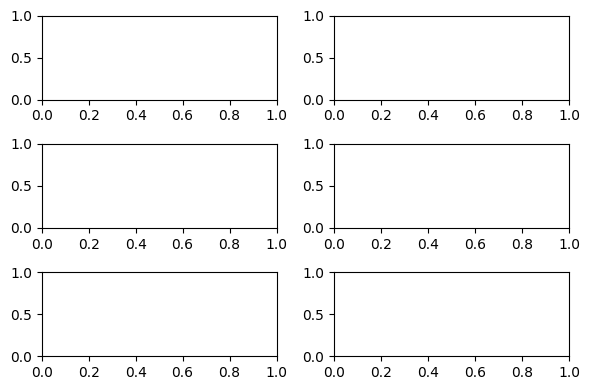

In [ ]:
# Plot some of the cat and dog images
fig, axs = plt.subplots(3,2,figsize=(6, 4))

for cat, dog, row in zip(training_cats, training_dogs, axs):
    for animal, ax in zip([cat, dog], row):
        animal=image.load_img(animal)
        animal=image.img_to_array(animal)
        animal/=255.0
        ax.imshow(animal)
        ax.axis('off')

plt.tight_layout()
plt.show()

## 2. EDA

Let's take a look at a few of our images to get a feel for how image data is structured.

### 2.1. Image data

In [4]:
# Load one of the images as an array and look at it's shape - what do you see, what are the dimensions? Are they what you expect?

In [5]:
# Plot a histogram of the three 2D arrays which comprise the image. What do you see?

### 2.2. Image dimensions

Let's take a look at a random sample of images from the dataset and see what their dimensions are.

In [6]:
# Loop over a few hundred images and extract their width and heigh, plot both as a histogram. What do you see, does this information matter to us, if so, how?

### 2.3. Image aspect ratios

In [7]:
# Plot a histogram of the image aspect ratios (i.e. width/height) What do you see, does this information matter to us, if so, how?

## 3. Build the model

### 3.1. Prepare images for streaming

In [8]:
def make_datasets(training_data_path: str, image_dim: int, batch_size: int=16):

    training_dataset=tf.keras.utils.image_dataset_from_directory(
        training_data_path,
        validation_split=0.2,
        subset='training',
        seed=315,
        image_size=(image_dim, image_dim),
        batch_size=batch_size
    ).repeat()

    validation_dataset=tf.keras.utils.image_dataset_from_directory(
        training_data_path,
        validation_split=0.2,
        subset='validation',
        seed=315,
        image_size=(image_dim, image_dim),
        batch_size=batch_size
    ).repeat()

    return training_dataset, validation_dataset

training_dataset, validation_dataset=make_datasets(training_data_path, 128)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


### 3.1. Model definition

In [9]:
def compile_model(image_dim, learning_rate):

    initializer=tf.keras.initializers.GlorotUniform(seed=315)

    model=Sequential([
        layers.Input((image_dim, image_dim, 3)),
        layers.Rescaling(1./255),
        layers.Conv2D(16, 3, padding='same', activation='relu', kernel_initializer=initializer),
        layers.MaxPooling2D(),
        layers.Conv2D(32, 3, padding='same', activation='relu', kernel_initializer=initializer),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, padding='same', activation='relu', kernel_initializer=initializer),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(128, activation='relu', kernel_initializer=initializer),
        layers.Dense(1, activation='sigmoid', kernel_initializer=initializer)
    ])

    optimizer=keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['binary_accuracy'])

    return model

model=compile_model(128, 0.001)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,097,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,120,993 (8.09 MB)

 Trainable params: 2,120,993 (8.09 MB)

 Non-trainable params: 0 (0.00 B)

### 3.2. Model training

In [10]:
training_results=model.fit(
  training_dataset,
  validation_data=validation_dataset,
  epochs=10,
  steps_per_epoch=5,
  validation_steps=5
)

Epoch 1/10
1/5 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - binary_accuracy: 0.1875 - loss: 0.7145

2024-11-21 20:03:03.764657: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 24772608 exceeds 10% of free system memory.
2024-11-21 20:03:03.816812: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 25952256 exceeds 10% of free system memory.
2024-11-21 20:03:03.881264: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 21233664 exceeds 10% of free system memory.


2/5 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - binary_accuracy: 0.3125 - loss: 0.7771

2024-11-21 20:03:03.999209: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 24772608 exceeds 10% of free system memory.
2024-11-21 20:03:04.030295: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 25952256 exceeds 10% of free system memory.


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 293ms/step - binary_accuracy: 0.4035 - loss: 0.8347 - val_binary_accuracy: 0.4500 - val_loss: 0.7030
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 244ms/step - binary_accuracy: 0.4630 - loss: 0.7006 - val_binary_accuracy: 0.6375 - val_loss: 0.6919
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 235ms/step - binary_accuracy: 0.5818 - loss: 0.6902 - val_binary_accuracy: 0.5125 - val_loss: 0.6924
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 230ms/step - binary_accuracy: 0.4866 - loss: 0.7035 - val_binary_accuracy: 0.4750 - val_loss: 0.7002
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 247ms/step - binary_accuracy: 0.3938 - loss: 0.7080 - val_binary_accuracy: 0.4500 - val_loss: 0.6939
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 223ms/step - binary_accuracy: 0.4877 - loss: 0.6919 - val_binary_accuracy: 0.5375 - val_loss: 0.6941
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 228ms/step - binary_accuracy: 0.5509 - loss: 0.6901 - val_binary_accuracy: 0.4875 - val_loss: 0.6922
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━

In [ ]:
# Take a look at what information 'training_results' contains. Plot the training and validation accuracy (and binary cross-entropy if you like) over the training epoch. Is the model learning? If not, what do you think is wrong?

### 3.3. Model optimization

In [ ]:
# Try optimizing the learning rate and the batch size using a few values near the default settings. Hint: use a loop!

In [ ]:
# Pick the best values for learning rate and batch size and train the model for longer

## 4. Evaluate the model

In [ ]:
# Test the model out on the test data - is it as good as you expected, given the training data? Worse? Better? Why?